In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

os.environ['DETECTRON2_DATASETS'] = '/home/nazir/datasets/'

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import random
import plotly.express as px
import json

import matplotlib.image as mpimg

from torch.utils.data import DataLoader, Subset

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from datasets.lost_and_found import LostAndFound
from datasets.mapillary import Mapillary
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from torchsummary import summary
from torchinfo import summary as summaryinfo
from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer

from analysis.ood import OODEvaluator, OODAnalyzer

from analysis.image import (
    show_image, 
    show_anomaly_map_without_void,
    show_anomaly_map_at_tpr_threshold,
    show_image_plotly
)

from analysis.sem_seg import SemSegAnalyzer


from analysis.uncertainty import entropy_torch

import cv2

plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'viridis'

import warnings
warnings.filterwarnings('ignore')

In [4]:
models_info = edict(
    r50=edict(
        ckpt='ckpts/cityscapes_faseg_r50.pth',
        config='configs/cityscapes/semantic-segmentation/faseg_r50.yaml'
    ),
   
)

In [7]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name='dec_layer_1'):
    
    config_path = models_info[name].config
    ckpt_path = models_info[name].ckpt
    
    if not os.path.exists(ckpt_path):
        ckpt_path = f"model_logs/{name}/model.pth"
        
    args = edict({'config_file': config_path, 'eval_only':True, 'opts':[]})
    config = setup(args)

    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_path, resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model, config


In [8]:
model_name = 'r50' 
 
model, config = get_model(model_name)

Loading config configs/cityscapes/semantic-segmentation/Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[01/26 09:56:04 detectron2]: Rank of current process: 0. World size: 1
[01/26 09:56:34 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.3
detectron2              0.6 @/home/nazir/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/nazir/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          520.61.05
CUDA_HOME               /usr/local/cuda
Pillow                  9.2.0
torchvision  

In [9]:
summaryinfo(model)

Layer (type:depth-idx)                                                      Param #
MaskFormer                                                                  --
├─ResNet: 1-1                                                               --
│    └─BasicStem: 2-1                                                       --
│    │    └─Conv2d: 3-1                                                     9,536
│    └─Sequential: 2-2                                                      --
│    │    └─BottleneckBlock: 3-2                                            75,008
│    │    └─BottleneckBlock: 3-3                                            70,400
│    │    └─BottleneckBlock: 3-4                                            70,400
│    └─Sequential: 2-3                                                      --
│    │    └─BottleneckBlock: 3-5                                            379,392
│    │    └─BottleneckBlock: 3-6                                            280,064
│    │    └─Bottleneck

# Data Configs

In [10]:
datasets_folder = '/home/nazir/datasets/'

# Configs for Datasets
bdd100k_config = edict(
    seg_downsample_rate=1,
    train_file='train_paths.txt',
    val_file='val_paths.txt',
    val_image_strategy='no_change',
    ignore_train_class=True,
    dataset_root=os.path.join(datasets_folder, 'bdd100k/seg')
)

cityscapes_config = edict(
    dataset_root=os.path.join(datasets_folder, 'cityscapes'),
)

road_anomaly_config = edict(
    dataset_root=os.path.join(datasets_folder,
                              'RoadAnomaly/RoadAnomaly_jpg'),
    test_image_strategy='no_change'
)

fishyscapes_laf_config = edict(
    dataset_root=os.path.join(datasets_folder, 'Fishyscapes'),
)

fishyscapes_static_config = edict(
    dataset_root=os.path.join(datasets_folder, 'Fishyscapes'),
)

road_anomaly_21_config = edict(
    dataset_root=os.path.join(datasets_folder,
                              'SegmentMeIfYouCan/dataset_AnomalyTrack'),
    dataset_mode='all'
)

road_obstacle_21_config = edict(
    dataset_root=os.path.join(datasets_folder,
                              'SegmentMeIfYouCan/dataset_ObstacleTrack'),
    dataset_mode='all'
)

laf_config = edict(
    dataset_root=os.path.join(datasets_folder, 'LostAndFound'),
)

# Create Datasets

In [11]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

cityscapes_dataset_train_ids = Cityscapes(cityscapes_config, transform=transform, split='val', target_type='semantic_trainids')

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_v1_dataset = FishyscapesStatic(
    hparams=fishyscapes_static_config, transforms=transform_fs_static, version=1)
loader_fs_static_v1 = DataLoader(fs_static_v1_dataset, batch_size=1, shuffle=False, num_workers=15)

fs_static_v2_dataset = FishyscapesStatic(
    hparams=fishyscapes_static_config, transforms=transform_fs_static, version=2)
loader_fs_static_v2 = DataLoader(fs_static_v2_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)

# Lost And Found
transforms_laf = A.Compose([
    ToTensorV2()
])

laf_dataset = LostAndFound(laf_config, transforms_laf) 
loader_laf = DataLoader(laf_dataset, batch_size=1, shuffle=False, num_workers=15)

transform_ro_21 = A.Compose([
    ToTensorV2()
])

ro_21_dataset = RoadObstacle21(road_obstacle_21_config, transforms=transform_ro_21)

# Anomaly Score Functions

In [12]:
def get_logits_plus(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda(), 'task':'semantic'}], **kwargs)
    
    if "return_aux" in kwargs and kwargs["return_aux"]:
        return out[0][0]["sem_seg"].unsqueeze(0), out[1]

    return out[0]['sem_seg'].unsqueeze(0)

def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda(), 'task':'semantic'}])
    
    return out[0]['sem_seg'].unsqueeze(0)
    
def get_neg_logit_sum(model, x, **kwargs):
    """
    This function computes the negative logits sum of a given logits map as an anomaly score.

    Expected input:
    - model: detectron2 style pytorch model
    - x: image of shape (1, 3, H, W)

    Expected Output:
    - neg_logit_sum (torch.Tensor) of shape (H, W)
    """

    with torch.no_grad():
        out = model([{"image": x[0].cuda(), 'task':'semantic'}])

    logits = out[0]['sem_seg']
    
    return -logits.sum(dim=0)

def get_max_logit(model, x, **kwargs):
    """
    This function computes the negative logits sum of a given logits map as an anomaly score.

    Expected input:
    - model: detectron2 style pytorch model
    - x: image of shape (1, 3, H, W)

    Expected Output:
    - neg_logit_sum (torch.Tensor) of shape (H, W)
    """

    with torch.no_grad():
        out = model([{"image": x[0].cuda(), 'task':'semantic'}])

    logits = out[0]['sem_seg']

    return -logits.max(dim=0).values


def get_nls_tanh(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda(), 'task':'semantic'}])

    logits = out[0]['sem_seg'].tanh()
    
    return -logits.tanh().sum(dim=0)
    
def resize_mask(m, shape):
    
    m = F.interpolate(
        m,
        size=(shape[0], shape[1]),
        mode="bilinear",
        align_corners=False,
    )
    return m

def logistic(x, k=1, x0=0, L=1):
    
    return L/(1 + torch.exp(-k*(x-x0)))

In [13]:
def get_seg_colormap(preds, colors):
    """
    Assuming preds.shape = (H,W)
    """
    H, W = preds.shape
    color_map = torch.zeros((H, W, 3)).long()
    
    for i in range(len(colors)):
        mask = (preds == i)
        if mask.sum() == 0:
            continue
        color_map[mask, :] = torch.tensor(colors[i])
    
    return color_map

def proc_img(img):
    
    if isinstance(img, torch.Tensor):
        ready_img = img.clone()
        
        if len(ready_img.shape) == 3 and ready_img.shape[0] == 3:
            ready_img = ready_img.permute(1, 2, 0)
        ready_img = ready_img.cpu()

    elif isinstance(img, np.ndarray):
        ready_img = img.copy()
        if len(ready_img.shape) == 3 and ready_img.shape[0] == 3:
            ready_img = ready_img.transpose(1, 2, 0)
    else:
        raise ValueError(
            f"Unsupported type for image: ({type(img)}), only supports numpy arrays and Pytorch Tensors")

    return ready_img

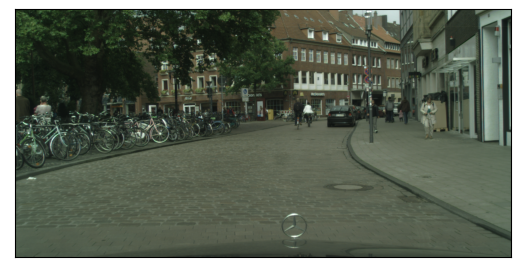

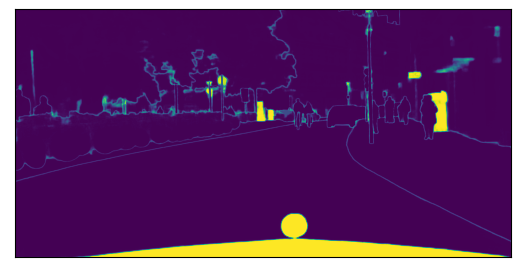

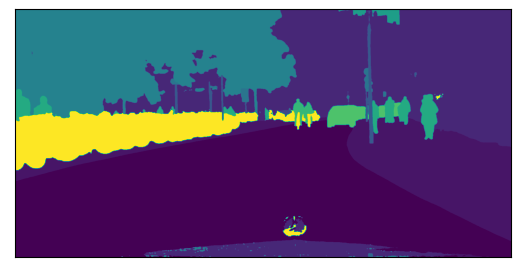

In [18]:
img, lbl = cityscapes_dataset[101]
show_image(img)
logits = get_logits(model, img.cuda().unsqueeze(0)).squeeze()
ml, pred = logits.max(dim=0)

show_image(-ml)
show_image(pred)

# Closed-Set Evalution

In [15]:
analyzer = OODAnalyzer(model=model, inference_func=get_logits, anomaly_score_func=get_neg_logit_sum, anomaly_id=1)

In [19]:
mIoU_cityscapes, mIoU_per_class = analyzer.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=20,
    return_per_class=True
 )

100%|██████████| 500/500 [01:54<00:00,  4.36it/s]


In [20]:
mIoU_per_class[:-1].mean(), mIoU_per_class

(tensor(0.8052),
 tensor([0.9842, 0.8702, 0.9307, 0.5592, 0.6340, 0.6874, 0.7451, 0.8063, 0.9295,
         0.6407, 0.9515, 0.8487, 0.6906, 0.9577, 0.8429, 0.9237, 0.8109, 0.6804,
         0.8038]))

## NLS Evaluation

In [22]:
ood_evaluator = OODEvaluator(model=model, inference_func=get_logits, anomaly_score_func=get_neg_logit_sum)

### Road Anomaly

In [23]:
anomaly_score_ra, ood_gts_ra = ood_evaluator.compute_anomaly_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=False,
)

metrics_ra = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

print(metrics_ra)

Dataset Iteration: 100%|██████████| 60/60 [00:07<00:00,  7.79it/s]


Calculating Metrics for 55296000 Points ...
Max Logits: AUROC score: 0.6465022138365402
Max Logits: AUPRC score: 0.20811306140371255
Max Logits: FPR@TPR95: 0.9279683039299804
{'auroc': 0.6465022138365402, 'aupr': 0.20811306140371255, 'fpr95': 0.9279683039299804}


### Fishyscapes

In [24]:
anomaly_score_fs_laf, ood_gts_fs_laf = ood_evaluator.compute_anomaly_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=False,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

print(metrics_fs_laf)

Dataset Iteration: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Calculating Metrics for 170619888 Points ...
Max Logits: AUROC score: 0.9004723847758396
Max Logits: AUPRC score: 0.22863047761177413
Max Logits: FPR@TPR95: 0.9280327521756152
{'auroc': 0.9004723847758396, 'aupr': 0.22863047761177413, 'fpr95': 0.9280327521756152}


# Max Logit Evaluation

In [25]:
ood_evaluator_ml = OODEvaluator(model=model, inference_func=get_logits, anomaly_score_func=get_max_logit)

### Road Anomaly ML

In [26]:
anomaly_score_ra_ml, ood_gts_ra = ood_evaluator_ml.compute_anomaly_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=False,
)

metrics_ra_ml = ood_evaluator_ml.evaluate_ood(
    anomaly_score=anomaly_score_ra_ml,
    ood_gts=ood_gts_ra,
    verbose=True
)

print(metrics_ra_ml)

Dataset Iteration: 100%|██████████| 60/60 [00:07<00:00,  8.34it/s]


Calculating Metrics for 55296000 Points ...
Max Logits: AUROC score: 0.7137000017493241
Max Logits: AUPRC score: 0.222098474896813
Max Logits: FPR@TPR95: 0.8768691720388108
{'auroc': 0.7137000017493241, 'aupr': 0.222098474896813, 'fpr95': 0.8768691720388108}


In [28]:
print(metrics_ra_ml)

{'auroc': 0.7137000017493241, 'aupr': 0.222098474896813, 'fpr95': 0.8768691720388108}


### Fishyscapes ML

In [27]:
anomaly_score_fs_laf_ml, ood_gts_fs_laf = ood_evaluator_ml.compute_anomaly_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=False,
)

metrics_fs_laf_ml = ood_evaluator_ml.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf_ml,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

print(metrics_fs_laf_ml)

Dataset Iteration: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Calculating Metrics for 170619888 Points ...
Max Logits: AUROC score: 0.9202117421101181
Max Logits: AUPRC score: 0.24215583771490978
Max Logits: FPR@TPR95: 0.4792087430337101
{'auroc': 0.9202117421101181, 'aupr': 0.24215583771490978, 'fpr95': 0.4792087430337101}
